In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from fleck import generate_spots, Stars
from scipy.stats import ks_2samp, anderson_ksamp

In [240]:
amps_fast = 2 * np.loadtxt('data/amps_fast.txt')

Text(0, 0.5, 'Probability Density')

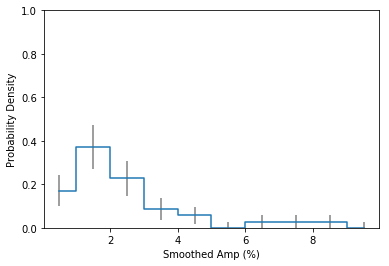

In [244]:
def norm_hist(x):
    n_bins = 10
    bin_range = [0, 10.0]
    freq, bin_edges = np.histogram(x, bins=n_bins, range=bin_range)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    dx = bin_edges[1] - bin_edges[0]
    norm = np.sum(freq * dx)
    normalized_freq = freq/norm
    normalized_freq_err = np.max([np.sqrt(freq)/norm, np.ones_like(freq)/norm], axis=0)
    return bin_centers, normalized_freq, normalized_freq_err

bin_centers, normalized_freq, normalized_freq_err = norm_hist(amps_fast)
plt.errorbar(bin_centers, normalized_freq, normalized_freq_err, 
             ls='steps-mid', ecolor='gray')
plt.ylim([0, 1])
plt.xlabel('Smoothed Amp (%)')
plt.ylabel('Probability Density')
# freq, bin_edges = np.histogram(amps_fast, bins=n_bins, range=bin_range, density=True)
# plt.plot(bin_centers, freq, ls='steps-mid--', color='r', zorder=100)

In [245]:
ld = [0.5079, 0.2239]
stars = Stars(spot_contrast=0.7, n_phases=30, u_ld=ld)

In [246]:
n_inclinations = 5000
spot_radius = 0.2
n_spots = 3

In [247]:
def chisquared(spot_radius, min_latitude):
    lons, lats, rads, incs = generate_spots(min_latitude=min_latitude, max_latitude=90, n_spots=n_spots,
                                            spot_radius=spot_radius, n_inclinations=n_inclinations)
    lcs = stars.light_curve(lons, lats, rads, incs)
    smoothed_amps = 100 * lcs.ptp(axis=0)
    bin_centers, norm_freq, norm_freq_err = norm_hist(smoothed_amps)
    anderson_stat = anderson_ksamp([smoothed_amps, amps_fast]).statistic
    chi2 = np.sum((norm_freq - normalized_freq)**2 / normalized_freq_err**2)
    return chi2, anderson_stat, smoothed_amps

radii_fast = np.arange(0.1, 0.45, 0.01)
lats_fast = np.arange(20, 85, 5)

chi2s = []
anderson_stats = []
for spot_radii in radii_fast:
    tmp1 = []
    tmp2 = []
    for min_lat in lats_fast: 
        c2, anderson_stat, smoothed_amps = chisquared(spot_radii, min_lat)
        tmp1.append(c2)
        tmp2.append(anderson_stat)
    chi2s.append(tmp1)
    anderson_stats.append(tmp2)

In [248]:
chi2s = np.array(chi2s)

chi2s.size

455

In [249]:
# plt.figure(figsize=(4, 3))
# dlats = lats_fast[1] - lats_fast[0]
# drads = radii_fast[1] - radii_fast[0]

# x, y = lats_fast, radii_fast[chi2s.argmin(axis=0)]#, chi2s.min(axis=0)

# cax = plt.imshow(np.log10(chi2s), origin='lower', aspect=200, #, vmin=5, vmax=10,
#                  extent=(lats_fast.min() - dlats/2, lats_fast.max() + dlats/2, 
#                          radii_fast.min() - drads/2, radii_fast.max() + drads/2))
# # plt.scatter(x, y, color='w', marker='.')
# cbar = plt.colorbar(cax)
# fs = 12
# cbar.set_label('$\log\, \chi^2$', fontsize=fs)
# plt.xlabel('Minimum latitude [degree]', fontsize=fs)
# plt.ylabel('$\\rm R_{spot}/R_{star}$', fontsize=fs)
# plt.savefig('plots/spot_minlat.pdf', bbox_inches='tight')

In [250]:
np.min(anderson_stats)

-0.51556812991612289

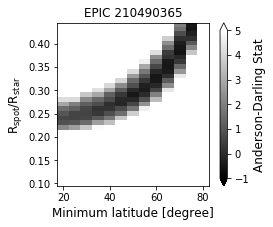

In [251]:
plt.figure(figsize=(4, 3))
dlats = lats_fast[1] - lats_fast[0]
drads = radii_fast[1] - radii_fast[0]

cax = plt.imshow(np.array(anderson_stats), origin='lower', aspect=200, vmin=-1, vmax=5,
                 extent=(lats_fast.min() - dlats/2, lats_fast.max() + dlats/2, 
                         radii_fast.min() - drads/2, radii_fast.max() + drads/2), 
                 cmap=plt.cm.gray)
# plt.scatter(x, y, color='w', marker='.')
cbar = plt.colorbar(cax, extend='both')
fs = 12
cbar.set_label('Anderson-Darling Stat', fontsize=fs)
plt.xlabel('Minimum latitude [degree]', fontsize=fs)
plt.ylabel('$\\rm R_{spot}/R_{star}$', fontsize=fs)
plt.title("EPIC 210490365")

plt.savefig('plots/spot_minlat.pdf', bbox_inches='tight')

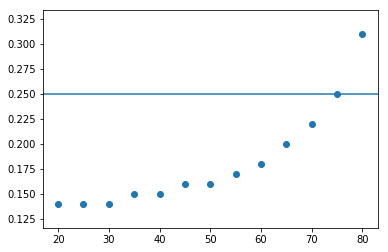

In [237]:
plt.scatter(x, y)
plt.axhline(0.25)

In [232]:
# radii_fast = np.arange(0.24, 0.29, 0.001)
# min_lat = 70
# chi2s = []
# for spot_radii in radii_fast:
#     chi2s.append(chisquared(spot_radii, min_lat)[0])

In [233]:
# plt.figure(figsize=(4, 3))
# plt.plot(radii_fast, chi2s, '.')
# poly = np.polyfit(radii_fast, chi2s, 2)

# polyval = np.polyval(poly, radii_fast)

# crit_chi2 = np.min(polyval) + 1 

# poly_minus_crit = polyval - crit_chi2
# inds = np.argwhere(np.sign(poly_minus_crit[1:]) != np.sign(poly_minus_crit[:-1]))

# plt.plot(radii_fast, polyval)

# plt.fill_between(radii_fast[inds[0]:inds[1]+1], polyval[inds[0]:inds[1]+1], crit_chi2, 
#                  color='C1', alpha=0.1)

# best_radius = np.mean(radii_fast[inds])
# radius_err = (radii_fast[inds][1] - radii_fast[inds][0]) / 2
# # plt.plot(radii_fast[inds], polyval[inds], '.')
# plt.title('Radius: ${0:.2f} \pm {1:.2f}$'.format(best_radius, radius_err[0]))
# # plt.axhline(crit_chi2, ls='--', color='gray')
# plt.xlabel('Spot Radius')
# plt.ylabel('$\chi^2$')
# for s in 'right top'.split(): 
#     plt.gca().spines[s].set_visible(False)
# plt.savefig('plots/chi2.pdf')

In [252]:
best_radius = 0.35
min_lat = 70
_, ad, ptp = chisquared(best_radius, min_lat)

_, normalized_freq_best, _ = norm_hist(ptp)

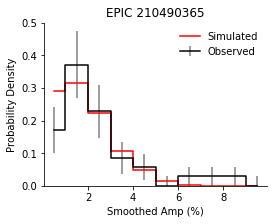

In [254]:

plt.figure(figsize=(4, 3))
plt.errorbar(bin_centers, normalized_freq, normalized_freq_err, 
             ls='steps-mid', ecolor='gray', color='k', label='Observed')

bin_centers, normalized_freq_best, normalized_freq_err_best = norm_hist(ptp)

plt.plot(bin_centers, normalized_freq_best, ls='steps-mid', color='r', label='Simulated')

# plt.plot(bin_centers, normalized_freq_lower, ls='steps-mid', color='C1')
# plt.plot(bin_centers, normalized_freq_upper, ls='steps-mid', color='C2')
plt.legend().get_frame().set_alpha(0)
plt.ylim([0, 0.5])
plt.title('$\\rm R_{{spot}}/R_s$: ${0:.2f} \pm {1:.2f}$'.format(best_radius, radius_err[0]))
plt.xlabel('Smoothed Amp (%)')
plt.ylabel('Probability Density')
plt.title("EPIC 210490365")

for s in ['right', 'top']: 
    plt.gca().spines[s].set_visible(False)
plt.savefig('plots/simulated_fast.pdf', bbox_inches='tight')

In [255]:
p_rot = 23.9
n_spots = 3
spot_radii = 0.2

amps_slow = 2 * np.loadtxt('data/amps_slow.txt')

In [256]:
def chisquared(spot_radius, min_latitude):
    lons, lats, rads, incs = generate_spots(min_latitude=min_latitude, max_latitude=90, n_spots=n_spots,
                                            spot_radius=spot_radius, n_inclinations=n_inclinations)
    lcs = stars.light_curve(lons, lats, rads, incs)
    smoothed_amps = 100 * lcs.ptp(axis=0)
    bin_centers, norm_freq, norm_freq_err = norm_hist(smoothed_amps)
    anderson_stat = anderson_ksamp([smoothed_amps, amps_slow]).statistic
    chi2 = np.sum((norm_freq - normalized_freq)**2 / normalized_freq_err**2)
    return chi2, anderson_stat, smoothed_amps

radii_slow = np.arange(0.1, 0.45, 0.01)
lats_slow = np.arange(20, 85, 5)

chi2s = []
anderson_stats = []
for spot_radii in radii_slow:
    tmp1 = []
    tmp2 = []
    for min_lat in lats_slow: 
        c2, anderson_stat, smoothed_amps = chisquared(spot_radii, min_lat)
        tmp1.append(c2)
        tmp2.append(anderson_stat)
    chi2s.append(tmp1)
    anderson_stats.append(tmp2)

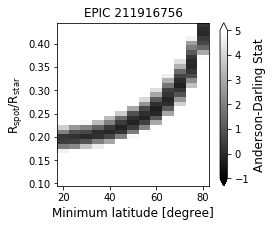

In [257]:
plt.figure(figsize=(4, 3))
dlats = lats_fast[1] - lats_fast[0]
drads = radii_fast[1] - radii_fast[0]

cax = plt.imshow(np.array(anderson_stats), origin='lower', aspect=200, vmin=-1, vmax=5,
                 extent=(lats_slow.min() - dlats/2, lats_slow.max() + dlats/2, 
                         radii_slow.min() - drads/2, radii_slow.max() + drads/2), 
                 cmap=plt.cm.gray)
cbar = plt.colorbar(cax, extend='both')
fs = 12
cbar.set_label('Anderson-Darling Stat', fontsize=fs)
plt.xlabel('Minimum latitude [degree]', fontsize=fs)
plt.ylabel('$\\rm R_{spot}/R_{star}$', fontsize=fs)
plt.title("EPIC 211916756")
plt.savefig('plots/spot_minlat_slow.pdf', bbox_inches='tight')

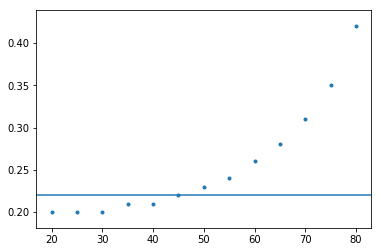

In [258]:
x, y = lats_slow, radii_slow[np.array(anderson_stats).argmin(axis=0)]

plt.axhline(0.22)
plt.scatter(x, y, marker='.')

In [259]:
best_radius = 0.35
min_lat = 70
_, ad, ptp = chisquared(best_radius, min_lat)

_, normalized_freq_best, _ = norm_hist(ptp)

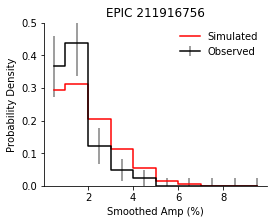

In [261]:
bin_centers, normalized_freq, normalized_freq_err = norm_hist(amps_slow)

plt.figure(figsize=(4, 3))
plt.errorbar(bin_centers, normalized_freq, normalized_freq_err, 
             ls='steps-mid', ecolor='gray', color='k', label='Observed')

bin_centers, normalized_freq_best, normalized_freq_err_best = norm_hist(ptp)

plt.plot(bin_centers, normalized_freq_best, ls='steps-mid', color='r', label='Simulated')

# plt.plot(bin_centers, normalized_freq_lower, ls='steps-mid', color='C1')
# plt.plot(bin_centers, normalized_freq_upper, ls='steps-mid', color='C2')
plt.legend().get_frame().set_alpha(0)
plt.ylim([0, 0.5])
plt.title("EPIC 211916756")
#plt.title('$\\rm R_{{spot}}/R_s$: ${0:.2f} \pm {1:.2f}$'.format(best_radius, radius_err[0]))
plt.xlabel('Smoothed Amp (%)')
plt.ylabel('Probability Density')
for s in ['right', 'top']: 
    plt.gca().spines[s].set_visible(False)
plt.savefig('plots/simulated_slow.pdf', bbox_inches='tight')